In [33]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import cv2
import tqdm
from sklearn.model_selection import StratifiedKFold

In [34]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


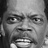

In [35]:
# loading a sample image
sample_image = Image.open("/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [36]:
np.array(sample_image).shape

(48, 48)

In [37]:
# normalize all the images from the dataset
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)


In [38]:
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'bad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Train_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

(18280, 200, 200, 1) (18280, 7)
(4570, 200, 200, 1) (4570, 7)


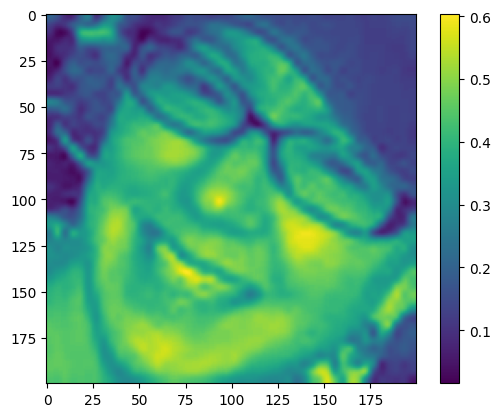

In [39]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

# Obstruct the Top 1/4 of the Facial Images

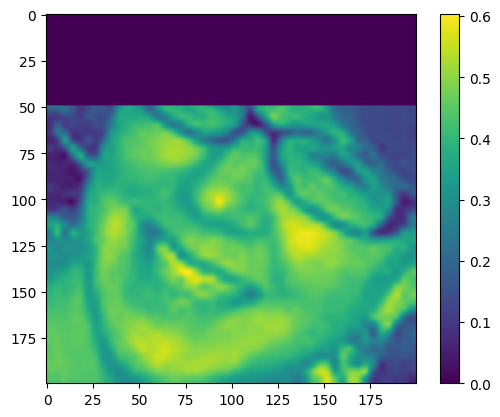

In [40]:
# obstruct the top 1/3 of the image
x_train_obstructed_up = x_train.copy()
x_train_obstructed_up[:,:50,:,:] = 0
x_val_obstructed_up = x_val.copy()
x_val_obstructed_up[:,:50,:,:] = 0

plt.imshow(x_train_obstructed_up[0,:,:,0])
plt.colorbar()

In [41]:
# train and fit a resnet50 model
resnet50_model_top = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_up[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_top.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [42]:
# add batch normalization and dropout
for layer in resnet50_model_top.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_top.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [43]:
n_epoch = 30
# train the model
resnet50_model_top.fit(x_train_obstructed_up, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_up, y_val),
                callbacks=[callback])

Epoch 1/30
572/572 [==============================] - 68s 59ms/step - loss: 1.7260 - categorical_accuracy: 0.3131 - val_loss: 1.9509 - val_categorical_accuracy: 0.3418
Epoch 2/30
572/572 [==============================] - 32s 56ms/step - loss: 1.3965 - categorical_accuracy: 0.4493 - val_loss: 1.5244 - val_categorical_accuracy: 0.3488
Epoch 3/30
572/572 [==============================] - 32s 55ms/step - loss: 1.2230 - categorical_accuracy: 0.5241 - val_loss: 1.3280 - val_categorical_accuracy: 0.4761
Epoch 4/30
572/572 [==============================] - 32s 56ms/step - loss: 1.1278 - categorical_accuracy: 0.5679 - val_loss: 16.5341 - val_categorical_accuracy: 0.3300
Epoch 5/30
572/572 [==============================] - 32s 56ms/step - loss: 1.0620 - categorical_accuracy: 0.5914 - val_loss: 1.2695 - val_categorical_accuracy: 0.5287
Epoch 6/30
572/572 [==============================] - 32s 56ms/step - loss: 0.9981 - categorical_accuracy: 0.6151 - val_loss: 1.8602 - val_categorical_accuracy

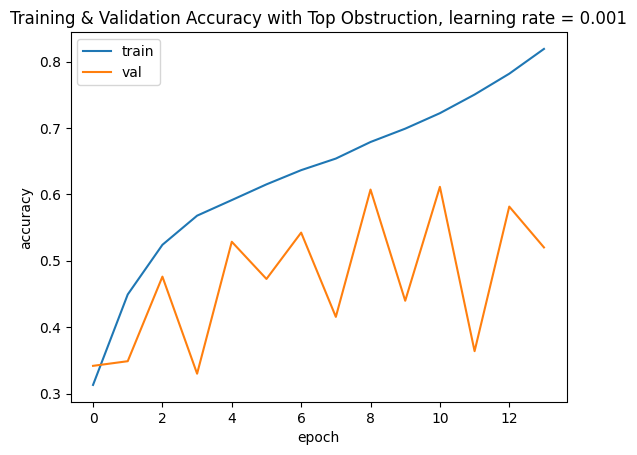

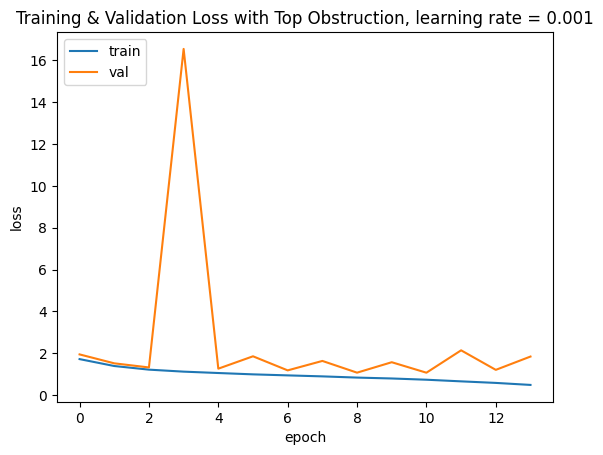

In [44]:
# plot the accuracy and loss
plt.plot(resnet50_model_top.history.history['categorical_accuracy'])
plt.plot(resnet50_model_top.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Top Obstruction, learning rate = 0.001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_top.history.history['loss'])
plt.plot(resnet50_model_top.history.history['val_loss'])
plt.title('Training & Validation Loss with Top Obstruction, learning rate = 0.001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [45]:
# save the model
resnet50_model_top.save_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_upper_face')

In [46]:
resnet50_model_top.load_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_upper_face')

# Test For the Top 1/4 of the Facial Images

In [47]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [48]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)

y_test = np.eye(len(emo_types))[y_test]
print(x_test.shape, y_test.shape)

(5400, 200, 200, 1) (5400, 7)


In [49]:
# Evaluate the model
loss, acc = resnet50_model_top.evaluate(x_test, y_test, verbose=2)
print("The accuracy of the Resnet50 model is: {:5.2f}%".format(100 * acc))
y_pred = resnet50_model_top.predict(x_test, verbose=2)

169/169 - 2s - loss: 3.5275 - categorical_accuracy: 0.3635 - 2s/epoch - 13ms/step
The accuracy of the Resnet50 model is: 36.35%
169/169 - 3s - 3s/epoch - 17ms/step


In [50]:
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.43      0.19      0.26       888
           1       0.10      0.11      0.10        83
           2       0.43      0.04      0.08       916
           3       0.82      0.45      0.58      1752
           4       0.50      0.37      0.42      1181
           6       0.18      0.91      0.30       580

    accuracy                           0.36      5400
   macro avg       0.41      0.34      0.29      5400
weighted avg       0.54      0.36      0.37      5400



In [51]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.18581081, 0.10843373, 0.04366812, 0.44863014, 0.36663844,
       0.9137931 ])

# Obstruct the Middle 1/4 of the Facial Images

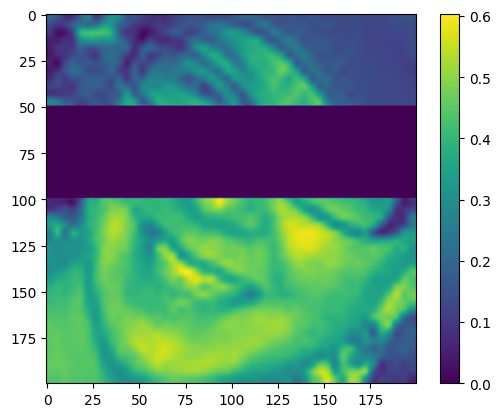

In [52]:
# obstruct the middle 1/4 of the images
x_train_obstructed_middle = x_train.copy()
x_train_obstructed_middle[:, 50:100, :, :] = 0
x_val_obstructed_middle = x_val.copy()
x_val_obstructed_middle[:, 50:100, :, :] = 0

plt.imshow(x_train_obstructed_middle[0,:,:,0])
plt.colorbar()

In [53]:
# train a resnet50 model
resnet50_model_middle = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_middle[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_middle.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [54]:
# add batch normalization and dropout
for layer in resnet50_model_middle.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_middle.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [55]:
n_epoch = 30
# train the model
resnet50_model_middle.fit(x_train_obstructed_middle, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_middle, y_val),
                callbacks=[callback])

Epoch 1/30
572/572 [==============================] - 68s 58ms/step - loss: 1.6858 - categorical_accuracy: 0.3618 - val_loss: 6.5181 - val_categorical_accuracy: 0.3162
Epoch 2/30
572/572 [==============================] - 32s 56ms/step - loss: 1.3566 - categorical_accuracy: 0.4730 - val_loss: 1.6739 - val_categorical_accuracy: 0.4083
Epoch 3/30
572/572 [==============================] - 32s 55ms/step - loss: 1.2454 - categorical_accuracy: 0.5255 - val_loss: 2.8145 - val_categorical_accuracy: 0.3497
Epoch 4/30
572/572 [==============================] - 32s 56ms/step - loss: 1.1491 - categorical_accuracy: 0.5578 - val_loss: 2.8719 - val_categorical_accuracy: 0.2232
Epoch 5/30
572/572 [==============================] - 32s 55ms/step - loss: 1.0712 - categorical_accuracy: 0.5881 - val_loss: 1.2743 - val_categorical_accuracy: 0.5269
Epoch 6/30
572/572 [==============================] - 32s 55ms/step - loss: 1.0121 - categorical_accuracy: 0.6141 - val_loss: 1.6074 - val_categorical_accuracy:

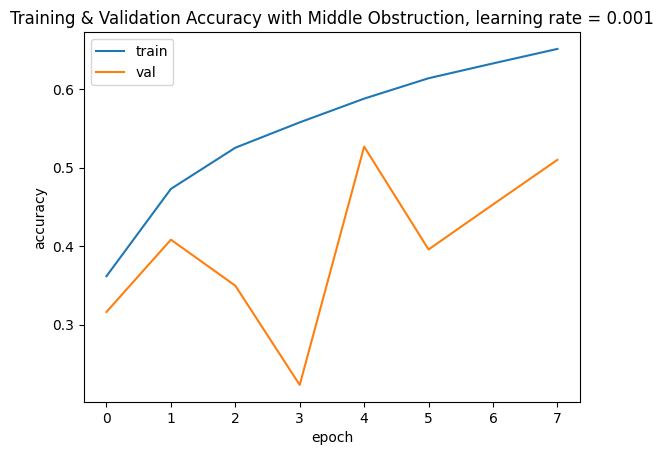

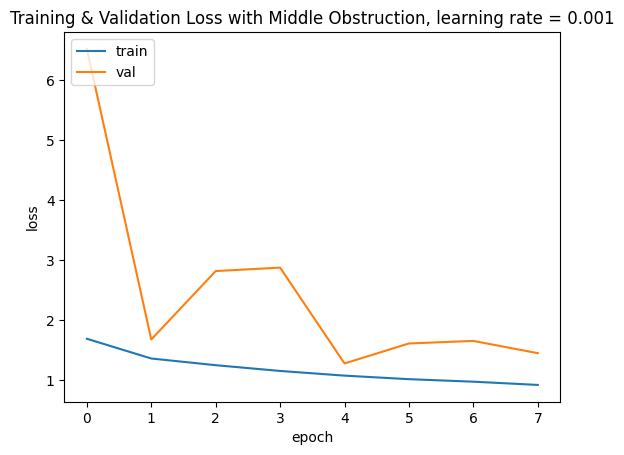

In [56]:
# plot the accuracy and loss
plt.plot(resnet50_model_middle.history.history['categorical_accuracy'])
plt.plot(resnet50_model_middle.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Middle Obstruction, learning rate = 0.001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_middle.history.history['loss'])
plt.plot(resnet50_model_middle.history.history['val_loss'])
plt.title('Training & Validation Loss with Middle Obstruction, learning rate = 0.001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [57]:
# save the model
resnet50_model_middle.save_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_middle_face')

# Test For the Middle 1/4 of the Facial Images

In [59]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)

y_test = np.eye(len(emo_types))[y_test]
print(x_test.shape, y_test.shape)

(5400, 200, 200, 1) (5400, 7)


In [60]:
# Evaluate the model
loss, acc = resnet50_model_middle.evaluate(x_test, y_test, verbose=2)
print("The accuracy of the Resnet50 model is: {:5.2f}%".format(100 * acc))
y_pred = resnet50_model_middle.predict(x_test, verbose=2)

169/169 - 2s - loss: 2.3485 - categorical_accuracy: 0.4122 - 2s/epoch - 13ms/step
The accuracy of the Resnet50 model is: 41.22%
169/169 - 3s - 3s/epoch - 16ms/step


In [61]:
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.36      0.03      0.06       888
           1       0.17      0.01      0.02        83
           2       0.37      0.18      0.24       916
           3       0.40      0.97      0.56      1752
           4       0.55      0.23      0.32      1181
           6       0.86      0.10      0.18       580

    accuracy                           0.41      5400
   macro avg       0.45      0.25      0.23      5400
weighted avg       0.46      0.41      0.32      5400



In [62]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.03378378, 0.01204819, 0.17576419, 0.97488584, 0.22777307,
       0.09827586])

# Obstruct the Bottom 1/2 of the Facial Images



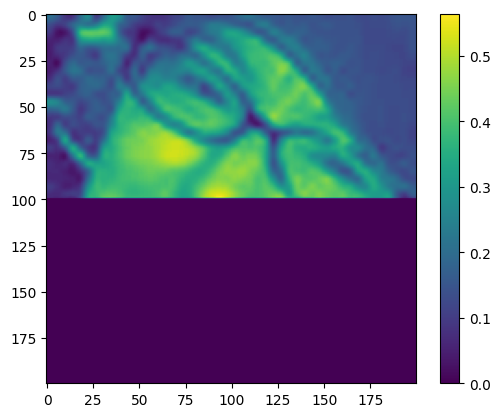

In [63]:
# obstruct the rest of the image, train and fit the resnet50 model
x_train_obstructed_bottom = x_train.copy()
x_train_obstructed_bottom[:, 100:, :, :] = 0
x_val_obstructed_bottom = x_val.copy()
x_val_obstructed_bottom[:, 100:, :, :] = 0

plt.imshow(x_train_obstructed_bottom[0,:,:,0])
plt.colorbar()

In [64]:
# train a resnet50 model
resnet50_model_bottom = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_bottom[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_bottom.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [65]:
# add batch normalization and dropout
for layer in resnet50_model_bottom.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_bottom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [66]:
n_epoch = 30
# train the model
resnet50_model_bottom.fit(x_train_obstructed_bottom, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_bottom, y_val),
                callbacks=[callback])

Epoch 1/30
572/572 [==============================] - 68s 58ms/step - loss: 1.6841 - categorical_accuracy: 0.3120 - val_loss: 1.8250 - val_categorical_accuracy: 0.3164
Epoch 2/30
572/572 [==============================] - 32s 56ms/step - loss: 1.5571 - categorical_accuracy: 0.3464 - val_loss: 1.6535 - val_categorical_accuracy: 0.3153
Epoch 3/30
572/572 [==============================] - 32s 56ms/step - loss: 1.5531 - categorical_accuracy: 0.3490 - val_loss: 1.6129 - val_categorical_accuracy: 0.3549
Epoch 4/30
572/572 [==============================] - 32s 56ms/step - loss: 1.5289 - categorical_accuracy: 0.3588 - val_loss: 1.5362 - val_categorical_accuracy: 0.3626
Epoch 5/30
572/572 [==============================] - 32s 56ms/step - loss: 1.5049 - categorical_accuracy: 0.3706 - val_loss: 1.6935 - val_categorical_accuracy: 0.3530
Epoch 6/30
572/572 [==============================] - 32s 56ms/step - loss: 1.4645 - categorical_accuracy: 0.3976 - val_loss: 1.6125 - val_categorical_accuracy:

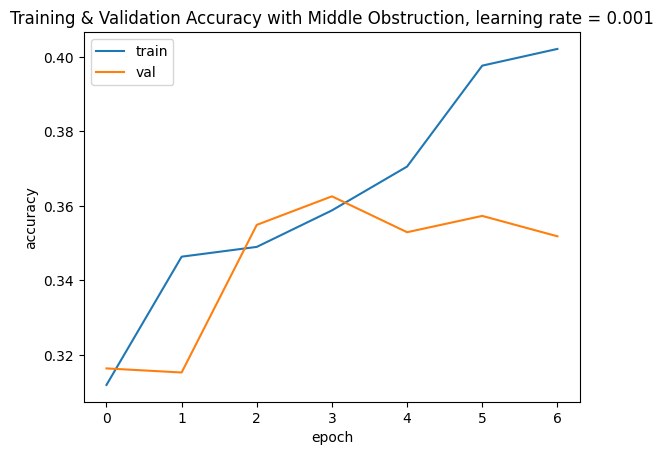

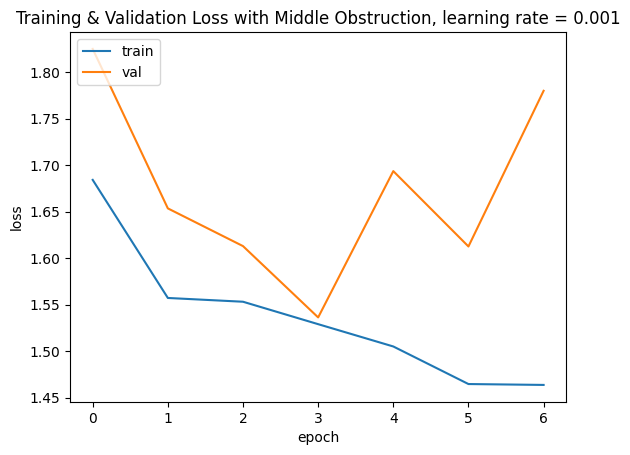

In [67]:
# plot the accuracy and loss
plt.plot(resnet50_model_bottom.history.history['categorical_accuracy'])
plt.plot(resnet50_model_bottom.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Middle Obstruction, learning rate = 0.001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_bottom.history.history['loss'])
plt.plot(resnet50_model_bottom.history.history['val_loss'])
plt.title('Training & Validation Loss with Middle Obstruction, learning rate = 0.001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [68]:
# save the model
resnet50_model_bottom.save_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_bottom_face')

# Test For the Bottom 1/2 of the Facial Images


In [70]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)

y_test = np.eye(len(emo_types))[y_test]
print(x_test.shape, y_test.shape)

(5400, 200, 200, 1) (5400, 7)


In [71]:
# Evaluate the model
loss, acc = resnet50_model_bottom.evaluate(x_test, y_test, verbose=2)
print("The accuracy of the Resnet50 model is: {:5.2f}%".format(100 * acc))
y_pred = resnet50_model_bottom.predict(x_test, verbose=2)

169/169 - 2s - loss: 2.5334 - categorical_accuracy: 0.2550 - 2s/epoch - 12ms/step
The accuracy of the Resnet50 model is: 25.50%
169/169 - 3s - 3s/epoch - 16ms/step


In [72]:
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.17      0.51      0.26       888
           1       0.00      0.00      0.00        83
           2       0.16      0.01      0.01       916
           3       0.33      0.52      0.41      1752
           4       0.17      0.00      0.00      1181
           6       0.50      0.01      0.01       580

    accuracy                           0.26      5400
   macro avg       0.22      0.17      0.12      5400
weighted avg       0.25      0.26      0.18      5400



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.51126126, 0.        , 0.00764192, 0.52054795, 0.00084674,
       0.00517241])